#### Process raw VR data to canonical
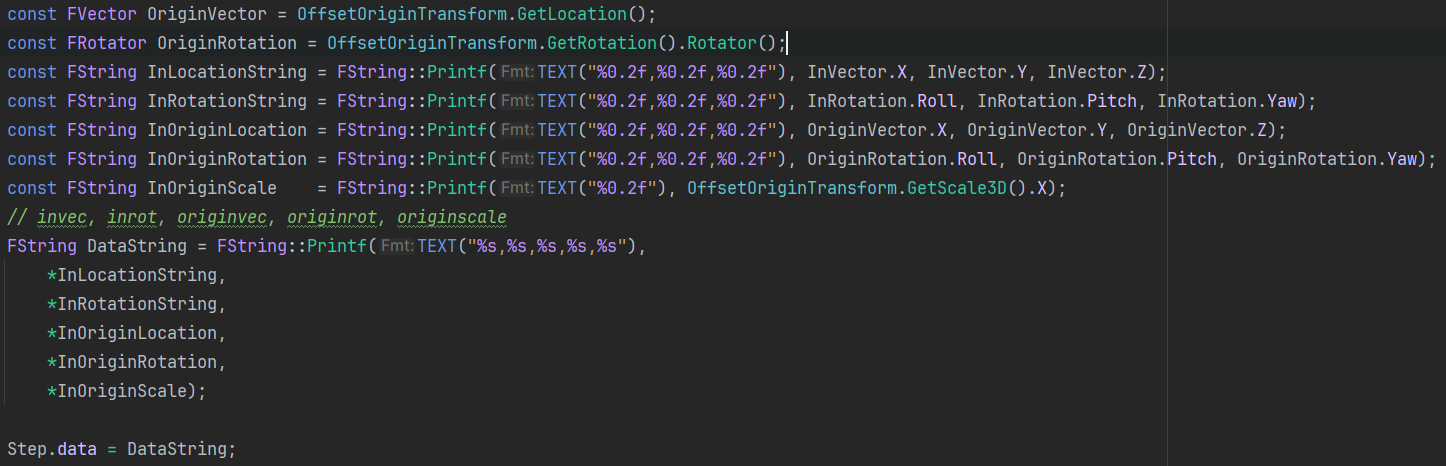

In [50]:
!pip install pandas -q

In [52]:
# Input log file
log_file = 'cellworld_log_edit.log'
# log_file = 'cellworld_vr_friday_4_4_finn_large.log'
# log_file = 'cellworld_vr_latest.log'

In [ ]:
# imports 
import cellworld_game as game
import cellworld as cw
import math
import os
from cellworld_game import CoordinateConverter 
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd

In [53]:
import re
output_file = f"{log_file.split('.')[0]}_parsed.csv"

# Regex to extract frame number and X, Y values from lines like:
# [timestamp][thread]LogTemp: [AExperimentClient::UpdatePreyPosition] Sent frame: 2 | location: X=1324.329 Y=-237.742 Z=246.764
pattern = re.compile(r'frame:\s*(\d+)\s*\|\s*location:\s*X=([-+]?\d*\.\d+|\d+)\s*Y=([-+]?\d*\.\d+|\d+)', re.IGNORECASE)
anchor_pattern = re.compile(r'AnchorLocation([AB]):\s*X=([-+]?\d*\.\d+|\d+)\s*Y=([-+]?\d*\.\d+|\d+)', re.IGNORECASE)

# List to store extracted data
extracted_data = []

# Read the log file
with open(log_file, "r", encoding="utf-8") as file:
    content = file.read()

# Find all matches
matches = pattern.findall(content)
matches_anchor = anchor_pattern.findall(content)
# Save extracted data
with open(output_file, "w", encoding="utf-8") as out_file:
    out_file.write("Frame,X,Y\n")  # CSV Header
    for frame, x, y in matches:
        out_file.write(f"{frame},{x},{y}\n")
        extracted_data.append((frame, x, y))

# Output results
print(f"Extracted {len(extracted_data)} entries and saved to {output_file}")

Extracted 0 entries and saved to cellworld_log_edit_parsed.csv


In [54]:
import re
import numpy as np
# Read the file content
with open(log_file, "r") as file:
    text = file.read()

# Define a regex pattern to match the location entry
# This pattern captures the x and y values as groups
pattern = r'"location"\s*:\s*{\s*"x"\s*:\s*(-?\d+\.?\d*),\s*"y"\s*:\s*(-?\d+\.?\d*)\s*}'

# Find all matches in the text
matches = re.findall(pattern, text)

# Optionally convert string matches to floats and create dictionaries
location_vectors = [np.array([float(x), float(y)]) for x, y in matches]

print(location_vectors)

# Define a regex pattern to capture the anchor label and coordinates
pattern = r'AnchorLocation(?P<label>[AB]):\s+X=(?P<X>-?\d+\.\d+)\s+Y=(?P<Y>-?\d+\.\d+)\s+Z=(?P<Z>-?\d+\.\d+)'

# Find all matches in the text
matches = re.finditer(pattern, text)

# Create a dictionary to store the results
results = {}
for match in matches:
    label = match.group('label')
    x = float(match.group('X'))
    y = float(match.group('Y'))
    z = float(match.group('Z'))
    results[f'AnchorLocation{label}'] = {"x": x, "y": y, "z": z}

print(results)
anchor_vectors = {k: np.array([v["x"], v["y"], v["z"]]) for k, v in results.items()}
AL_A = anchor_vectors["AnchorLocationA"]
AL_B = anchor_vectors["AnchorLocationB"]

difference = AL_B - AL_A
print(anchor_vectors)

[array([-1977.27612305,  -739.20452881]), array([-1977.22705078,  -739.2175293 ]), array([-1977.19726562,  -739.23504639]), array([-1977.16589355,  -739.2522583 ]), array([-1977.03442383,  -739.32525635]), array([-1977.03442383,  -739.32525635]), array([-1977.03442383,  -739.32525635]), array([-1977.03442383,  -739.32525635]), array([-1977.03442383,  -739.32525635]), array([-1976.87145996,  -739.40380859]), array([-1976.84143066,  -739.41741943]), array([-1976.84143066,  -739.41741943]), array([-1976.84143066,  -739.41741943]), array([-1976.84143066,  -739.41741943]), array([-1976.83422852,  -739.41845703]), array([-1976.83422852,  -739.41845703]), array([-1976.83422852,  -739.41845703]), array([-1976.82287598,  -739.43859863]), array([-1976.82287598,  -739.43859863]), array([-1976.8092041 ,  -739.45568848]), array([-1976.79223633,  -739.45819092]), array([-1976.77758789,  -739.46496582]), array([-1976.79711914,  -739.47277832]), array([-1976.81445312,  -739.48205566]), array([-1976.79

In [ ]:
# load file
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
# csv_file = output_file
csv_file = 'cellworld_vr_latest_parsed.csv'

# Read the CSV file
df = pd.read_csv(csv_file)
df.set_index(df.columns[0], inplace=True)

x_vals = df['X']
y_vals = df['Y']

if matches_anchor: 
    print(matches_anchor)
    originA_raw = [float(matches_anchor[0][1]), float(matches_anchor[0][2])]
    originB_raw = [float(matches_anchor[1][1]), float(matches_anchor[1][2])]


# diff = originA_raw - originB_raw

# print(diff)
print(originA_raw)
print(originB_raw)

df.head()

#### Test VRCoordinateConverter Class

In [55]:
import cellworld_game as game
import numpy as np
import math
class VRCoordinateConverter:
    def __init__(self):
        print("Initialised")
        self.origin_transform = {'direction':None, 'scale': None}
        self.origin = {'entry':None, 'exit':None}
        self.active = False
        pass
    
    def set_origin(self, originA:list=None, originB:list=None, flipY:bool=True):
        self.origin['entry'] = [originA[0], originA[1]] # flip x/y to y/-x
        self.origin['exit']  = [originB[0], originB[1]] # flip x/y to y/-x
        entry = np.array([self.origin['entry'][0], self.origin['entry'][1]])
        exit = np.array([self.origin['exit'][0], self.origin['exit'][1]])
        x_left, y_left = entry
        x_right, y_right = exit
        self.x_left = x_left
        self.y_left = y_left
        self.dx = x_right - x_left
        self.dy = y_right - y_left
        self.denominator = self.dx**2 + self.dy**2
        self.transform = np.array([[self.dx, self.dy], 
                                   [-self.dy, self.dx]])
        self.transform *= 1/self.denominator
        self.origin_transform['direction'] = game.Direction.radians(self.origin['entry'], self.origin['exit']) ##  + np.pi/2
        self.origin_transform['scale']     = game.Point.distance(self.origin['entry'] ,  self.origin['exit'])
        self.active = True
        print(f'[set origin] Active: {self.active}')
        print(f'[set origin] Origin: {self.origin}')
        print(f'[set origin] Origin Tranform: {self.origin_transform}')
    
    def vr_to_canonical_v1(self,x,y)->game.Point:
        dirp = game.Direction.radians(self.origin['entry'], (x,y)) - self.origin_transform['direction']
        distp = game.Point.distance(self.origin['entry'],(x,y)) / self.origin_transform['scale']
        return game.Point.move((0, .5), distance=distp, direction_radians=dirp)
    
    def vr_to_canon(self, x, y)->game.Point:
        # x_prime = ((x - self.x_left) *self.dx + ( y - self.y_left)*self.dy)/self.denominator
        # y_prime = (-(x - self.x_left)*self.dy + (y - self.y_left)*self.dx)/self.denominator + 0.5
            # y_prime = (-(x - self.x_left)*self.dy + (y - self.y_left)*self.dx)/self.denominator + 0.5
        x -= self.x_left
        y -= self.y_left
        point = np.array([x, y])
        point_prime = np.dot(self.transform, point)
        point_prime[1] *= -1
        point_prime[1] += 0.5 # y
        return [float(point_prime[0]),float(point_prime[1])]
        # return game.Point(point_prime[0], point_prime[1])
    
    def vr_to_canonical(self,x,y)->game.Point:
        dirp = game.Direction.radians(self.origin['entry'], (x,y)) - self.origin_transform['direction']
        distp = game.Point.distance(self.origin['entry'],(x,y)) / self.origin_transform['scale'] 
        point = game.Point.move((0, .5), distance=distp, direction_radians=dirp)         
        # y = point[1]*math.sqrt(3)*0.5  + 0.5 - (math.sqrt(3)/4) 
        # offset = (1-math.sqrt(3)*0.5)
        # magic_num = 0.0275
        # p = (point[0]+magic_num, point[1] - offset - magic_num)
        return point

    def canonical_to_vr(self, px, py): 
        transform_inverse = np.linalg.inv(self.transform)
        point = np.array([px, py])
        point[1] -= 0.5
        point_prime = np.dot(transform_inverse, point)
        return [float(point_prime[0]), float(point_prime[1])]
        # direction = game.Direction.radians((0, 0.5), (px, py)) + self.origin_transform['direction']
        # distance = game.Point.distance((0, 0.5), (px, py)) * self.origin_transform['scale']
        # return game.Point.move(self.origin['entry'], distance=distance, direction_radians=direction)  

In [56]:
vrcc = VRCoordinateConverter()
vrcc.set_origin(originA=AL_A, originB=AL_B)
# vrcc.vr_to_canon()
drotated_points_vcc = []
dunrotated_points_vcc = []
idx = 0

for v in zip(location_vectors):
    # theta = np.pi
    # rot_mat = np.matrix([[np.cos(theta), -np.sin(theta)]
    #                      ,[
    #            np.sin(theta), np.cos(theta)]])
    # print(v[0])
    q = v[0]
    # q[0] += 0.5
    # print(v[0].size)
    # # t = np.array([v[0], v[1]])
    # q = np.matmul(rot_mat, v[0])
    # print(np.dot(q, v[0]))
    # print(q[0, 0])
    pc = vrcc.vr_to_canon(v[0][0], v[0][1])
    drotated_points_vcc.append(pc)
drotated_points_vcc = np.array(drotated_points_vcc)
left_vertex_index = np.argmin(drotated_points_vcc[:, 0])
left_vertex_current = drotated_points_vcc[left_vertex_index]
print("Left vertex (before translation):", left_vertex_current)
offset = np.array([0, 0.5]) - left_vertex_current
adjusted_points = drotated_points_vcc

# for x, y in zip(x_vals, y_vals):
#     pc = vrcc.vr_to_canon(x, y)
#     drotated_points_vcc.append(pc)

# adjusted_points = drotated_points_vcc
# for x, y in zip(x_vals, y_vals):
#   pc = vrcc.vr_to_canonical(x, y)
# #   pc = vrcc.vr_to_canonical(x,y)
# #   pvr = vrcc.canonical_to_vr(pc[0],pc[1])
#   # print(f'xvr: {x:0.2f}, xvr->xc: {pc[0]:0.2f} | xc->xvr {pvr[0]:0.2f} | error: {x-pvr[0]:0.2f}')
#   # print(f'yvr: {y:0.2f}, yvr->xc: {pc[1]:0.2f} | yc->yvr {pvr[1]:0.2f} | error: {y-pvr[1]:0.2f}')
#   drotated_points_vcc.append(pc)
# #   dunrotated_points_vcc.append(pvr)
#   idx +=1 
# print(drotated_points_vcc)
# drotated_points_vcc = np.array(drotated_points_vcc)

Initialised
[set origin] Active: True
[set origin] Origin: {'entry': [np.float64(-757.052), np.float64(2300.288)], 'exit': [np.float64(-1824.402), np.float64(-874.237)]}
[set origin] Origin Tranform: {'direction': -1.8951457984748372, 'scale': 3349.1558635162087}
Left vertex (before translation): [0.00738029 0.49800387]


#### Plot Raw data (trajectory is entry to exit door)

PRE-FLIP ON Y
Total time: 109.376 s (1.823 min)
Average time per episode: 109.376 s


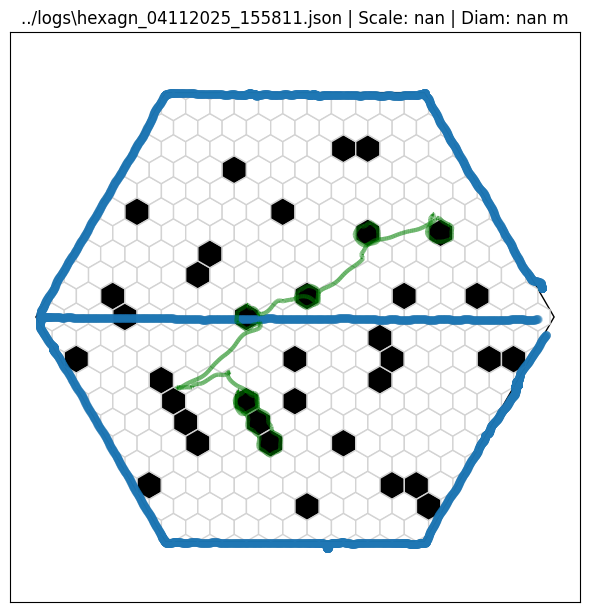

In [ ]:
file = os.path.join('../logs','hexagn_04112025_161800.json')
def basic_plot(file=None, scale:float=np.nan):
    w = cw.World.get_from_parameters_names('hexagonal',"canonical",'21_05')
    d = cw.Display(w, fig_size=(6,6), padding=0.1, cell_edge_color="lightgrey", background_color="white", habitat_edge_color="black")
    n     = 0
    t_sum = 0
    d.ax.set_title(f'{file} | Scale: {scale} | Diam: {scale*2.35:0.2f} m')
    exp = cw.Experiment.load_from_file(file)
    
    for idx in range(len(exp.episodes)):
        episode = exp.episodes[idx]
        preyt = episode.trajectories.get_agent_trajectory('prey')
        print('PRE-FLIP ON Y')
        # for step in preyt:
            # step.location.y -= 0.5
            # step.location.y *= -1
            # step.location.y += 0.5
        d.add_trajectories(preyt, colors = {'prey': 'green'}, alphas = {'prey': .7}, zorder = 7)
        # d.add_trajectories(predt, colors = {'predator': 'red'}, alphas = {'predator': .7}, zorder = 7)
        # summary info 
        n+=1 
        t_sum += len(preyt) * np.diff(preyt.get('time_stamp')).mean()

    print(f'Total time: {t_sum:.3f} s ({t_sum/60:.3f} min)')
    print(f'Average time per episode: {t_sum / n :.3f} s')
    return d

# w = cw.World.get_from_parameters_names("hexagonal", "canonical", "21_05")
# dis = cw.Display(w,fig_size=(10,10))

# plt.figure(figsize=(5,5))
# plt.plot(dunrotated_points_vcc[:, 0], dunrotated_points_vcc[:, 1], linewidth=1.5,label='v2')
drotated_points_vcc = np.array(drotated_points_vcc)
# plt.plot(adjusted_points[:, 0], adjusted_points[:, 1], linewidth=1.5,label='v1')
# plt.legend()
x1 = np.linspace(0, 1, 100)
y1 = np.linspace(0, 0, 100)
adjusted_points_v1 = np.column_stack((x1, y1))

# For v2: a line from (0,1) to (1,0)
x2 = np.linspace(0, 0, 100)
y2 = np.linspace(1, 0, 100)

adjusted_points_v2 = np.column_stack((x2, y2))
# print(adjusted_points_v2)
# Plot the points as lines with different colors and labels
# plt.figure(figsize=(8, 6))
d = basic_plot(file=file)
plt.scatter(adjusted_points[:, 0], adjusted_points[:, 1], linewidth=0.1,label='v1',alpha=0.2)


In [ ]:
def hexagon_points(R, n_points_per_edge=10):
    """
    Generate points along the edges of a regular hexagon with side length R,
    with the left vertex (angle 180°) placed at the origin.
    
    The hexagon vertices (in order) are computed by:
      - Vertex 3: leftmost point at (0, 0)
      - Vertex 2: (0.5*R, sqrt(3)/2*R)
      - Vertex 1: (1.5*R, sqrt(3)/2*R)
      - Vertex 0: (2*R, 0)
      - Vertex 5: (1.5*R, -sqrt(3)/2*R)
      - Vertex 4: (0.5*R, -sqrt(3)/2*R)
    
    The vertices are defined so that walking from vertex 3 to vertex 2, then 1, 0, 5, 4, and back to 3
    forms the hexagon in counterclockwise order.
    """
    # Define the vertices of the hexagon (translated so that vertex 3 is at (0,0))
    vertices = np.array([
        [2*R, 0],                    # Vertex 0 (angle 0°)
        [1.5*R, np.sqrt(3)/2 * R],     # Vertex 1 (angle 60°)
        [0.5*R, np.sqrt(3)/2 * R],     # Vertex 2 (angle 120°)
        [0, 0],                      # Vertex 3 (angle 180°) -> left vertex at the origin
        [0.5*R, -np.sqrt(3)/2 * R],    # Vertex 4 (angle 240°)
        [1.5*R, -np.sqrt(3)/2 * R],    # Vertex 5 (angle 300°)
        [2*R, 0]                     # Close the hexagon (repeat Vertex 0)
    ])
    
    points = []
    # Loop over each consecutive pair of vertices
    for i in range(len(vertices) - 1):
        start = vertices[i]
        end = vertices[i + 1]
        # Generate points along the segment from start to end.
        # We use linspace to interpolate points (excluding the end point to avoid duplicates).
        for t in np.linspace(0, 1, n_points_per_edge, endpoint=False):
            pt = start + t * (end - start)
            points.append(pt)
    # Append the last vertex to complete the loop.
    points.append(vertices[-1])
    
    return np.array(points)

# Parameters: side length and number of points per edge
R = 1.0
points = hexagon_points(R, n_points_per_edge=10)
points *= 0.5
# Separate the points into x and y arrays
x = points[:, 0]
y = points[:, 1]
y += 0.5
print("x points:", x)
print("y points:", y)

w = cw.World.get_from_parameters_names("hexagonal", "canonical", "21_05")
dis = cw.Display(w,fig_size=(4,4))

# plt.figure(figsize=(5,5))
# plt.plot(dunrotated_points_vcc[:, 0], dunrotated_points_vcc[:, 1], linewidth=1.5,label='v2')
drotated_points_vcc = np.array(drotated_points_vcc)
plt.plot(x,y, linewidth=1.5,label='v1')
plt.legend()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path

def generate_large_hexagon(R):
    """
    Generate vertices for a flat-topped hexagon with side length R,
    then translate it so that its leftmost vertex is at (0, 0).
    
    For a flat-topped hexagon, the vertices (centered at the origin) can be computed by:
      vertex = R * [cos(30+60*i), sin(30+60*i)] for i in 0,...,5.
    """
    angles = np.deg2rad(np.array([30, 90, 150, 210, 270, 330]))
    vertices = R * np.column_stack((np.cos(angles), np.sin(angles)))
    # Find the leftmost vertex and translate so that it becomes (0,0)
    left_idx = np.argmin(vertices[:, 0])
    translation = -vertices[left_idx]
    vertices = vertices + translation
    # Close the polygon by appending the first vertex at the end
    vertices = np.vstack([vertices, vertices[0]])
    return vertices

def generate_small_hexagon(center, a):
    """
    Generate vertices for a flat-topped hexagon with side length a,
    centered at the given coordinate.
    
    The vertices are computed with angles 30, 90, ... 330 degrees.
    """
    angles = np.deg2rad(np.array([30, 90, 150, 210, 270, 330]))
    vertices = np.array([center + a * np.array([np.cos(angle), np.sin(angle)]) for angle in angles])
    # Close the hexagon
    vertices = np.vstack([vertices, vertices[0]])
    return vertices

# Parameters
R_large = 1.0    # Side length of the large hexagon
a_small = 0.2    # Side length of the small hexagons

# Generate large hexagon vertices (with left vertex at (0,0))
large_hex = generate_large_hexagon(R_large)
large_hex_path = Path(large_hex)

# Get bounding box for the large hexagon
min_x, min_y = np.min(large_hex, axis=0)
max_x, max_y = np.max(large_hex, axis=0)

# For a flat-topped hexagon grid:
# Horizontal center spacing is 3/2 * a_small.
dx = 3/2 * a_small
# Vertical spacing is sqrt(3) * a_small.
dy = np.sqrt(3) * a_small

# Generate candidate centers over the bounding box (with some margin)
x_candidates = np.arange(min_x - a_small, max_x + a_small, dx)
y_candidates = np.arange(min_y - a_small, max_y + a_small, dy)

small_hex_centers = []
for i, x in enumerate(x_candidates):
    for j, y in enumerate(y_candidates):
        # Offset every other column for a proper hex grid (using odd-q offset)
        if i % 2 == 1:
            center = np.array([x, y + dy/2])
        else:
            center = np.array([x, y])
        # Only keep centers that lie within the large hexagon
        if large_hex_path.contains_point(center):
            small_hex_centers.append(center)
small_hex_centers = np.array(small_hex_centers)

plt.figure(figsize=(6, 6))
# Plot the large hexagon boundary
plt.plot(large_hex[:, 0], large_hex[:, 1], 'k-', lw=2, label="Large Hexagon")

# Plot each small hexagon
for center in small_hex_centers:
    small_hex = generate_small_hexagon(center, a_small)
    plt.plot(small_hex[:, 0], small_hex[:, 1], 'b-', lw=1)
    # Optionally, mark the center
    plt.plot(center[0], center[1], 'ro', markersize=3)

plt.title("Tiling the Interior of a Hexagon with Smaller Hexagons")
plt.xlabel("X")
plt.ylabel("Y")
plt.axis('equal')
plt.legend()
plt.grid(True)
plt.show()